Обучение модели классификации

# Загрузка библиотек

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from torchvision import transforms
from torch.optim import lr_scheduler
from IPython.display import clear_output
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score

In [2]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

In [3]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
RANDOM_STATE = 42

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Загрузка данных

In [6]:
# # colab data unar

# !sudo apt install unar
# !unar 'drive/MyDrive/sorted_data_merged.rar'

# Формирование выборки для обучения и теста

In [7]:
df_markup = pd.read_pickle('df_markup.pkl')

In [8]:
TEST_SIZE = 0.15

In [9]:
df_markup.loc[
    df_markup['target']!='receipt', 'target'
] = 'other'

In [10]:
flag_augm = df_markup['filename'].apply(lambda x: 'augm' in x)
train_augm = df_markup.loc[
    flag_augm
]
df_markup = df_markup.loc[~flag_augm]
train, test = train_test_split(
    df_markup, stratify=df_markup['target'], 
    random_state=RANDOM_STATE, test_size=TEST_SIZE)
train = pd.concat((train, train_augm))

In [11]:
train['target'].value_counts()

target
other      9223
receipt    2146
Name: count, dtype: int64

In [12]:
test['target'].value_counts()

target
other      393
receipt    379
Name: count, dtype: int64

In [13]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomCrop((500, 500)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
    normalize
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    normalize
])

In [14]:
dict_label = {
    'other': 0,
    'receipt': 1
}

In [15]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, target_column, transform=None, filename=False):
        self.data = dataframe
        self.transform = transform
        self.target_column = target_column
        self.filename = filename

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = dict_label[self.data.iloc[idx][self.target_column]]
        file_name = self.data.iloc[idx]['filename']
        img = Image.open(file_name).convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.filename:
            return img, label, file_name
        return img, label

In [16]:
NUM_WORKERS = 0
BATCH_SIZE = 32

train_dataset = CustomDataset(train, target_column='target', transform=train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

test_dataset = CustomDataset(test, target_column='target', transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Обучение модели

In [17]:
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [18]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses,
            test_losses,
            train_accuracies,
            test_accuracies,
            train_f1s,
            test_f1s,
            train_precisions,
            test_precisions,
            train_recalls,
            test_recalls):
    clear_output()
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    plt.rcParams['font.size'] = '12'
    axs[0, 0].plot(range(1, len(train_losses) + 1), train_losses, label='train', marker='o')
    axs[0, 0].plot(range(1, len(test_losses) + 1), test_losses, label='test', marker='o')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    axs[0, 1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train', marker='o')
    axs[0, 1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test', marker='o')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()

    axs[0, 2].plot(range(1, len(train_f1s) + 1), train_f1s, label='train', marker='o')
    axs[0, 2].plot(range(1, len(test_f1s) + 1), test_f1s, label='test', marker='o')
    axs[0, 2].set_ylabel('F1')
    axs[0, 2].legend()

    axs[1, 0].plot(range(1, len(train_precisions) + 1), train_precisions, label='train', marker='o')
    axs[1, 0].plot(range(1, len(test_precisions) + 1), test_precisions, label='test', marker='o')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].legend()

    axs[1, 1].plot(range(1, len(train_recalls) + 1), train_recalls, label='train', marker='o')
    axs[1, 1].plot(range(1, len(test_recalls) + 1), test_recalls, label='test', marker='o')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].legend()

    # for ax in axs:
    #     ax.set_xlabel('epoch')
    #     ax.legend()
    plt.legend()
    plt.xlabel("Epoch")
    plt.show()

def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy, train_f1, train_precision, train_recall = 0.0, 0.0, 0.0, 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        # labels = labels.type(torch.LongTensor)
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        # Calculate F1-score
        predictions = logits.argmax(dim=1)
        train_f1 += f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')
        train_precision += precision_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')
        train_recall += recall_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    train_f1 /= len(train_loader)
    train_precision /= len(train_loader)
    train_recall /= len(train_loader)

    return train_loss, train_accuracy, train_f1, train_precision, train_recall


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy, test_f1, test_precision, test_recall = 0.0, 0.0, 0.0, 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        # labels = labels.type(torch.LongTensor)
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()
        # Calculate F1-score
        predictions = logits.argmax(dim=1)
        test_f1 += f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')
        test_precision += precision_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')
        test_recall += recall_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    test_f1 /= len(test_loader)
    test_precision /= len(test_loader)
    test_recall /= len(test_loader)

    return test_loss, test_accuracy, test_f1, test_precision, test_recall


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs, target='receipt'):
    train_losses, train_accuracies, train_f1s, train_precisions, train_recalls = [], [], [], [], []
    test_losses, test_accuracies, test_f1s, test_precisions, test_recalls = [], [], [], [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy, train_f1, train_precision, train_recall = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy, test_f1, test_precision, test_recall = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        train_f1s += [train_f1]
        train_precisions += [train_precision]
        train_recalls += [train_recall]

        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        test_f1s += [test_f1]
        test_precisions += [test_precision]
        test_recalls += [test_recall]
        plot_losses(
            train_losses,
            test_losses,
            train_accuracies,
            test_accuracies,
            train_f1s,
            test_f1s,
            train_precisions,
            test_precisions,
            train_recalls,
            test_recalls
          )
        torch.save(model, models_dir+f'/model_{target}_ep{epoch}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_losses[-1],
            'test_loss': test_losses[-1],
            'train_accuracy': train_accuracies[-1],
            'test_accuracy': test_accuracies[-1],
            'train_f1': train_f1s[-1],
            'test_f1': test_f1s[-1],
            'train_precision': train_precisions[-1],
            'test_precision': test_precisions[-1],
            'train_recall': train_recalls[-1],
            'test_recall': test_recalls[-1]
        }, models_dir+f'/model_{target}_ep{epoch}.pth')

    return train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s, train_precisions, test_precisions, train_recalls, test_recalls

In [19]:
model_receipt = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
model_receipt.classifier[3] = torch.nn.Linear(1280, 2)

In [20]:
num_epochs = 40
model_receipt = model_receipt.to(device)
optimizer = torch.optim.SGD(model_receipt.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


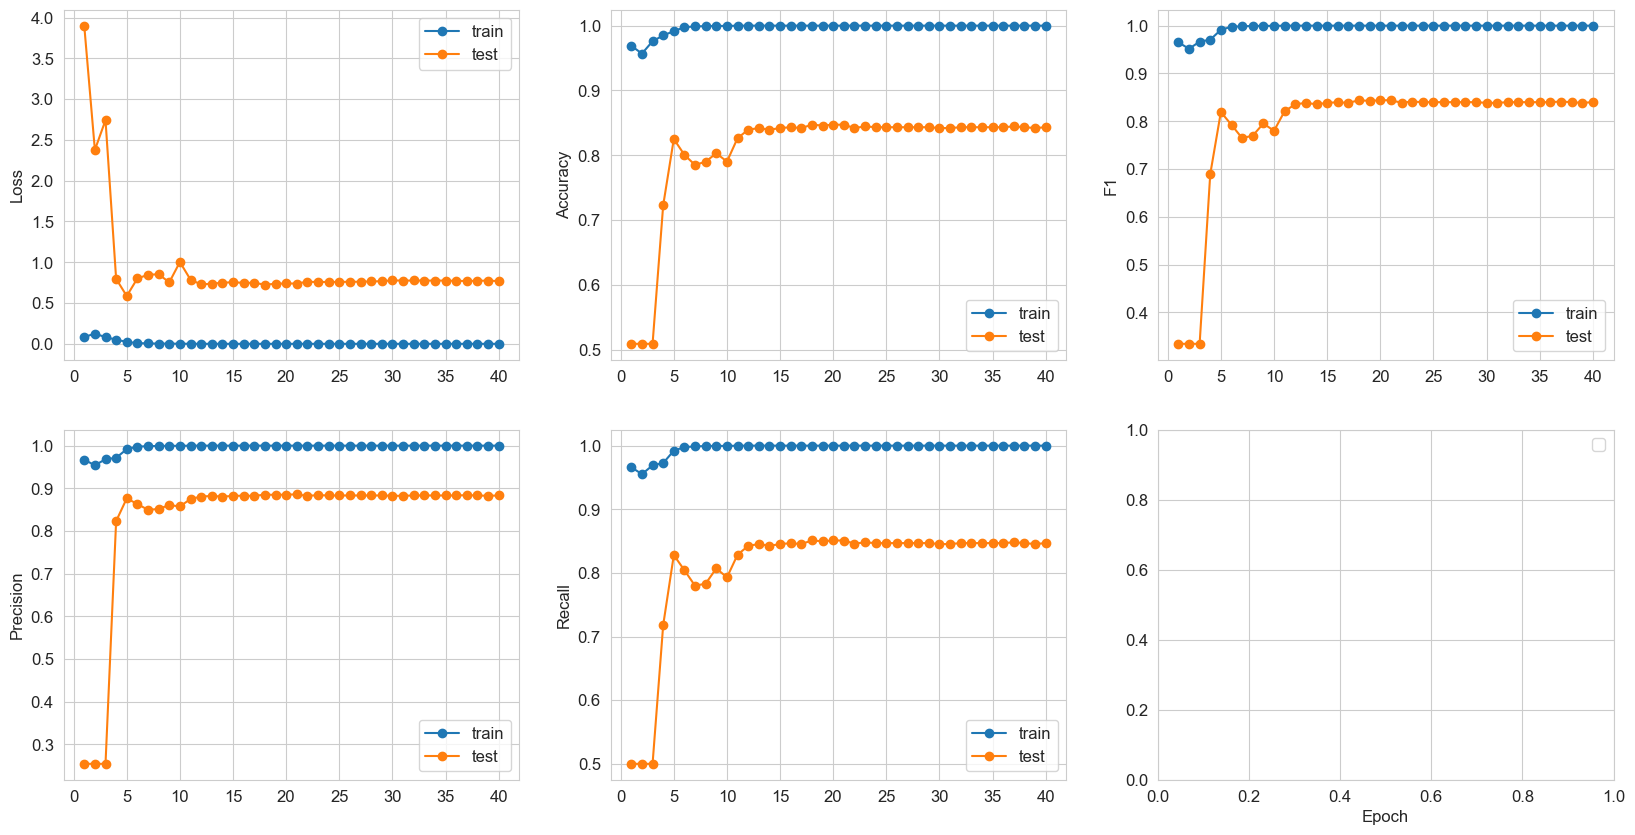

In [21]:
train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s, train_precisions, test_precisions, train_recalls, test_recalls = train(
    model_receipt, optimizer, scheduler, criterion, train_dataloader, test_dataloader, num_epochs, target='receipt'
)

# Валидация

In [23]:
all_labels, all_preds_receipt = [], []
for images, labels in tqdm(test_dataloader):
    images = images.to(device)  # images: batch_size x num_channels x height x width
    predictions_receipt = model_receipt(images).argmax(dim=1)
    all_labels.append(labels)
    all_preds_receipt.append(predictions_receipt)

100%|██████████| 25/25 [00:13<00:00,  1.79it/s]


In [24]:
all_preds_receipt = [torch.Tensor.cpu(x).numpy() for x in all_preds_receipt]
df_val = pd.DataFrame({
    'labels': np.hstack(all_labels),
    'predictions_receipt': np.hstack(all_preds_receipt)
})
df_val.head()

,labels,predictions_receipt
0,0,0
1,1,0
2,0,0
3,1,1
4,1,1


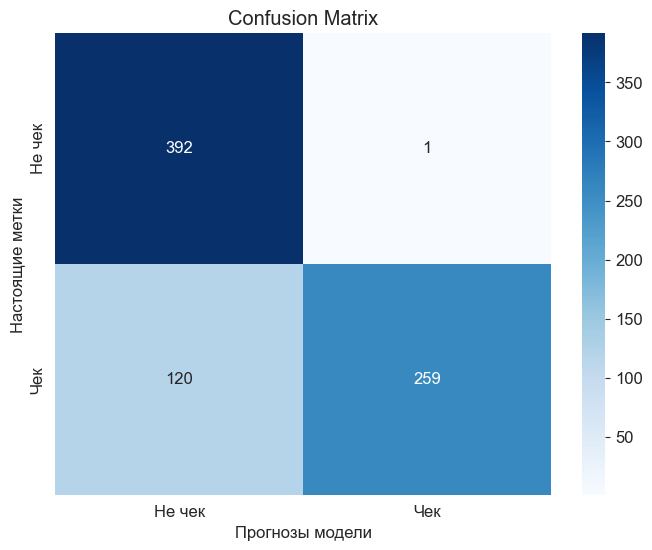

In [25]:
cm = confusion_matrix(
    df_val['labels'], 
    df_val['predictions_receipt'], 
    labels=[0, 1]
)
class_names = ['Не чек', 'Чек']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Прогнозы модели')
plt.ylabel('Настоящие метки')
plt.show()

In [56]:
all_labels, all_preds_receipt = [], []
for images, labels in tqdm(test_dataloader):
    images = images.to(device)  # images: batch_size x num_channels x height x width
    logit = model_receipt(images)
    p = torch.nn.functional.softmax(logit, dim=1)
    # to calculate loss using probabilities you can do below 
    all_labels.append(labels)
    all_preds_receipt.append(torch.Tensor.cpu(p).detach().numpy()[:, 1])

100%|██████████| 25/25 [00:44<00:00,  1.77s/it]


In [59]:
all_preds_receipt = np.hstack(all_preds_receipt)

In [62]:
f1s, precisions, recalls = [], [], []
thresholds = np.linspace(0, 1, 500)
for threshold in tqdm(thresholds):
    f1s.append(f1_score(all_preds_receipt>threshold, np.hstack(all_labels)))
    precisions.append(precision_score(all_preds_receipt>threshold, np.hstack(all_labels)))
    recalls.append(recall_score(all_preds_receipt>threshold, np.hstack(all_labels)))

 90%|█████████ | 451/500 [00:00<00:00, 562.00it/s]C:\Users\Dm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 500/500 [00:00<00:00, 556.19it/s]


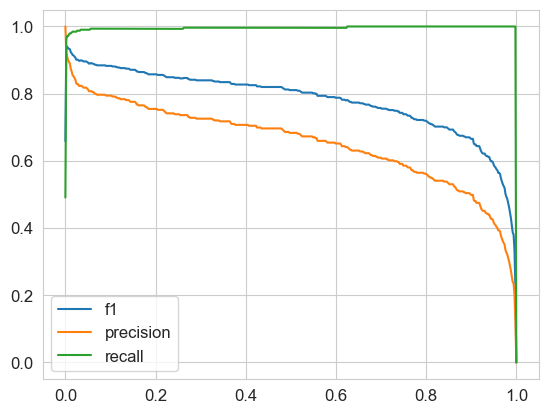

In [66]:
pd.DataFrame(
    {
        'f1': f1s,
        'precision': precisions,
        'recall': recalls
    }, index=thresholds
).plot()
plt.legend()

# Валидация с порогом

In [73]:
all_labels, all_preds_receipt = [], []
for images, labels in tqdm(test_dataloader):
    images = images.to(device)  # images: batch_size x num_channels x height x width
    logit = model_receipt(images)
    p = torch.nn.functional.softmax(logit, dim=1)
    all_labels.append(labels)
    all_preds_receipt.append(torch.Tensor.cpu(p).detach().numpy()[:, 1])

100%|██████████| 25/25 [00:48<00:00,  1.94s/it]


In [89]:
threshold = 0.01 / 10
# all_preds_receipt = [torch.Tensor.cpu(x).numpy() for x in all_preds_receipt]
df_val = pd.DataFrame({
    'labels': np.hstack(all_labels),
    'predictions_receipt': np.hstack(all_preds_receipt)>threshold
})
df_val.head()

,labels,predictions_receipt
0,0,False
1,1,True
2,0,False
3,1,True
4,1,True


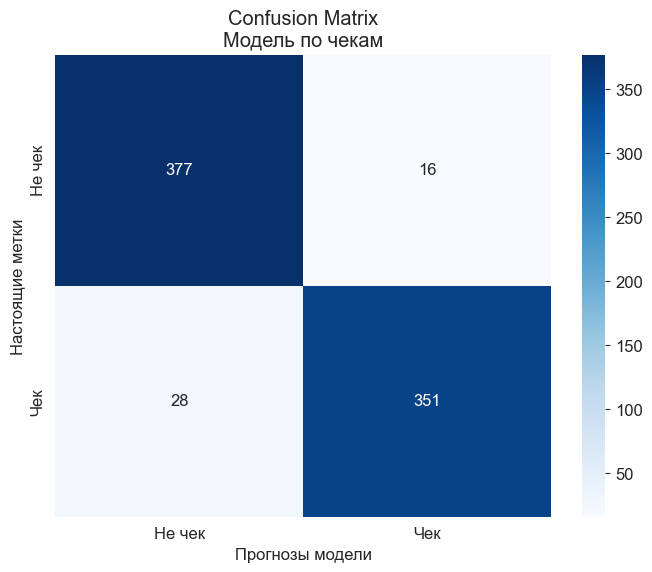

In [92]:
cm = confusion_matrix(
    df_val['labels'], 
    df_val['predictions_receipt'], 
    labels=[0, 1]
)
class_names = ['Не чек', 'Чек']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix\nМодель по чекам')
plt.xlabel('Прогнозы модели')
plt.ylabel('Настоящие метки')
plt.show()